<a href="https://colab.research.google.com/github/element-fi/elf-simulations/blob/main/examples/notebooks/hyperdrive.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperdrive Simulation
We use the following setup:
- 90 day term
- 200 agents, 100 randomly open and close longs, the other 100 randomly open and close shorts
- agents are initialized with 1 million of capital, trading 10% of their budget per trade
- they trade at random intervals calibrated to be roughly twice per term (1 open 1 close)
- there is one Liquidity Provider which deposits 500 million of liquidity

For details on the simulation framework, please see our <a href="https://elfpy.element.fi/">simulation documentation</a>

### Install repo requirements & import packages

In [1]:
try: # install dependencies only if running on google colab
    import google.colab # check if running in colab
    !pip install --upgrade pip
    !pip install --upgrade notebook google-colab flask numba
    !pip install -r https://raw.githubusercontent.com/element-fi/elf-simulations/main/requirements.txt 
    !pip install git+https://github.com/element-fi/elf-simulations.git
except:
    print("running locally & trusting that you have the dependencies installed")

running locally & trusting that you have the dependencies installed


In [2]:
from __future__ import annotations

import logging

import numpy as np
from numpy.random._generator import Generator
from scipy import special
import matplotlib.pyplot as plt
import pandas as pd

from elfpy import DEFAULT_LOG_MAXBYTES
from elfpy.types import MarketActionType, MarketAction, WEI
from elfpy.simulators import Simulator
from elfpy.agent import Agent
from elfpy.markets import Market
from elfpy.utils.config import Config
from elfpy.utils import sim_utils
from elfpy.pricing_models.hyperdrive import HyperdrivePricingModel
import elfpy.utils.outputs as output_utils
import elfpy.utils.parse_config as config_utils
import elfpy.utils.post_processing as post_processing
from elfpy.types import MarketState, StretchedTime
from elfpy.utils.outputs import get_gridspec_subplots

### Setup experiment parameters

In [3]:
log_filename = "./hyperdrive.log" # Output filename for logging

log_level = "WARNING" # Logging level, should be in ["DEBUG", "INFO", "WARNING"]
max_bytes = DEFAULT_LOG_MAXBYTES # Maximum log file output size, in bytes. More than 100 files will cause overwrites.
pricing_model = "HyperdriveCustom" # can be yieldspace or hyperdrive

num_trading_days = 90 # Number of simulated trading days
num_position_days = num_trading_days/365
blocks_per_day = 10 #7200 # Blocks in a given day (7200 means ~12 sec per block)
trade_fee_percent = 0.10 # fee percent collected on trades
redemption_fee_percent = 0.005 # 5 bps

num_agents = 100 # int specifying how many agents you want to simulate
agent_budget = 18_000_000 # max money an agent can spend
trade_chance = 2/(num_trading_days*blocks_per_day) # on a given block, an agent will trade with probability `trade_chance`

target_pool_apr = 0.03 # target pool APR of the initial market after the LP
target_liquidity = 500_000_000 # target total liquidity of the initial market, before any trades

vault_apr_init = 0.0 # Initial vault APR
vault_apr_jump_size = 0.001 # Scale of the vault APR change (vault_apr (+/-)= jump_size)
vault_jumps_per_year = 0#4 # The average number of jumps per year
vault_apr_jump_direction = "random_weighted" # The direction of a rate change. Can be 'up', 'down', or 'random'.
vault_apr_lower_bound = 0.01 # minimum allowable vault apr
vault_apr_upper_bound = 0.01 # maximum allowable vault apr

### Define experiment config dictionary

In [4]:
config_dict = {
    "title": "Hyperdrive demo",
    "market": {
        "vault_apr": {"type": "constant", "value": 0.05}, # we will override this later
        "min_vault_age": 0,
        "max_vault_age": 1,
        "base_asset_price": 1,
    },
    "amm": {
        "pricing_model_name": pricing_model,
        "floor_fee": 0,
    },
    "simulator": {
        "num_trading_days": num_trading_days,
        "num_blocks_per_day": blocks_per_day,
        "num_position_days": num_position_days,
        "precision": 64,
        "agent_policies": [],
        "shuffle_users": True,
        "init_lp": False,
        "compound_vault_apr": True,
        "random_seed": 123,
        "logging_level": log_level,
    }
}

### Setup pricing model

In [5]:
class HyperdriveCustomPricingModel(HyperdrivePricingModel):
    
    def calc_time_stretch(self, apr) -> float:
        return 10

### Setup agents

In [6]:
class SmartAgent(Agent):
    """
    Agent that compares the current fixed and variable rates, then opens or closes seemingly profitable
    longs or shorts. Trades that close the spread between the rates are deemed profitable
    """

    def __init__(self, rng: Generator, trade_chance: float, wallet_address: int, budget: int = 10_000) -> None:
        """Add custom stuff then call basic policy init"""
        self.trade_long = True  # default to allow easy overriding
        self.trade_short = True  # default to allow easy overriding
        self.trade_chance = trade_chance
        self.rng = rng
        super().__init__(wallet_address, budget)

    def action(self, market: Market) -> list[MarketAction]:
        """Implement a smart user strategy

        The agent performs one of four possible trades:
            [OPEN_LONG, OPEN_SHORT, CLOSE_LONG, CLOSE_SHORT]
            with the following conditions: 
            - Close actions can only be performed after open actions
            - Only actions that make financial sense will be performed
                - If no positions and fixed rate >= variable rate, OPEN_LONG
                - If no positions and fixed rate < variable rate, OPEN_SHORT
                - If has a LONG and fixed rate >= variable rate, do nothing
                - If has a LONG and fixed rate < variable rate and has loss, do nothing
                - If has a LONG and fixed rate < variable rate and has profit, CLOSE_LONG
                - If has a SHORT and fixed rate >= variable rate, do nothing
                - If has a SHORT and fixed rate < variable rate and has loss, do nothing
                - If has a SHORT and fixed rate < variable rate and has profit, CLOSE_LONG

        The amount opened and closed is as large as the lower value between the user's entire budget, and
        the trade size needed to close the spread between the variable and fixed rates, within constraints
        given by market reserve levels

        Parameters
        ----------
        market : Market
            the trading market

        Returns
        -------
        action_list : list[MarketAction]
        """
        gonna_trade = self.rng.choice([True, False], p=[self.trade_chance, 1-self.trade_chance])
        if not gonna_trade:
            return []
        # User can always open a trade, and can close a trade if one is open
        available_actions = []
        if self.trade_long is True:
            available_actions+=[MarketActionType.OPEN_LONG]
        if self.trade_short is True:
            available_actions+=[MarketActionType.OPEN_SHORT]
        has_opened_short = bool(any((short.balance > 0 for short in self.wallet.shorts.values())))
        if has_opened_short:
            available_actions = [MarketActionType.CLOSE_SHORT]
        has_opened_long = bool(any((long.balance > 0 for long in self.wallet.longs.values())))
        if has_opened_long:
            available_actions = [MarketActionType.CLOSE_LONG]
        action_type = self.rng.choice(available_actions, size=1) # choose one random trade type
        # trade amount is also randomly chosen
    
        # We can get the market's current rates from the market object
        current_vault_apr = market.market_state.vault_apr
        current_pool_apr = market.rate
        
        if action_type == MarketActionType.OPEN_SHORT:
#             random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
            max_short = self.get_max_short(market) 
            
            # If variable rate is greater than fixed, consider shorting
            if current_vault_apr > current_pool_apr:
                # We need to figure out the trade size to make the pool_apr converge with the market rate
                # This calculates the reserves of each asset needed to get the desired APR
#                 desired_share_reserves, desired_bond_reserves = market.pricing_model.calc_liquidity(
#                     market_state=market.market_state,
#                     target_liquidity=market.pricing_model.calc_total_liquidity_from_reserves_and_price(
#                         market.market_state,
#                         market.market_state.share_price,
#                     ),
#                     target_apr=current_vault_apr,
#                     position_duration=market.position_duration,
#                 )
                
#                 trade_size = market.market_state.bond_reserves - desired_bond_reserves
            
                if max_short > WEI: # if max_short is greater than the minimum eth amount
                    trade_amount = np.maximum(WEI, np.minimum(max_short, self.budget)) # WEI <= trade_amount <= max_short
                    action_list = [
                        self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=market.time),
                    ]
                else:
                    action_list = []
            else: # no short is possible
                action_list = []
        elif action_type == MarketActionType.OPEN_LONG:
            if current_vault_apr < current_pool_apr:
                random_normal = self.rng.normal(loc=self.budget * 0.1, scale=self.budget * 0.01)
                max_long = self.get_max_long(market)
                if max_long > WEI: # if max_long is greater than the minimum eth amount
                    trade_amount = np.maximum(WEI, np.minimum(max_long, random_normal))
                    action_list = [
                        self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=market.time),
                    ]
                else:
                    action_list = []
            else:
                action_list = []
        elif action_type == MarketActionType.CLOSE_SHORT:
            if current_vault_apr < current_pool_apr:
                short_time = self.rng.choice(list(self.wallet.shorts))
                trade_amount = self.wallet.shorts[short_time].balance # close the full trade
                open_share_price = self.wallet.shorts[short_time].open_share_price
                action_list = [
                    self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=short_time, open_share_price=open_share_price),
                ]
            else:
                action_list = []
        elif action_type == MarketActionType.CLOSE_LONG:
            if current_vault_apr > current_pool_apr:
                long_time = self.rng.choice(list(self.wallet.longs))
                trade_amount = self.wallet.longs[long_time].balance # close the full trade
                action_list = [
                    self.create_agent_action(action_type=action_type, trade_amount=trade_amount, mint_time=long_time),
                ]
            else:
                action_list = []
        else:
            action_list = []
        return action_list


class LPAgent(Agent):
    """
    Adds a large LP
    """
    def action(self, market: Market):
        """
        implement user strategy
        LP if you can, but only do it once
        short if you can, but only do it once
        """
        if self.wallet.lp_tokens > 0: # has already opened the lp
            action_list = []
        else:
            action_list = [
                self.create_agent_action(
                    action_type=MarketActionType.ADD_LIQUIDITY, trade_amount=self.budget
                ),
            ]
        return action_list


def get_example_agents(rng: Generator, budget: float, new_agents: int, existing_agents: int = 0, direction: str = None) -> list[Agent]:
    """Instantiate a set of custom agents"""
    agents = []
    for address in range(existing_agents, existing_agents + new_agents):
        agent = SmartAgent(
            rng=rng,
            trade_chance=trade_chance,
            wallet_address=address,
            budget=budget,
        )
        if direction is not None:
            if direction == "short":
                agent.trade_long = False
            if direction == "long":
                agent.trade_short = False
        agent.log_status_report()
        agents += [agent]
    return agents


### Define vault apr process

In [7]:
def DSR_historical(num_dates=90):
    dsr = pd.read_csv('https://s3-sim-repo-0.s3.us-east-2.amazonaws.com/Data/HIST_DSR_D.csv', index_col=0, infer_datetime_format=True)
    dsr.index = pd.to_datetime(dsr.index)
    dsr = dsr.resample('D').mean()
    min_date = dsr.index.min()
    max_date = dsr.index.max()
    date_range = max_date - min_date
    new_date_range = min_date + date_range * np.linspace(0, 1, num_dates)
    dsr_new = dsr.reindex(new_date_range, method='ffill')
    dsr_new = dsr_new.reset_index(drop=True)
    return dsr_new["DAI_SAV_RATE"].to_list()

### Setup experiment vault apr using parameters specified above

In [8]:
# override_dict specifies overrides for the config AND the random variables
override_dict = {
    "pricing_model_name": pricing_model,
    "num_trading_days": num_trading_days,
    "num_blocks_per_day": blocks_per_day,
    "target_liquidity": target_liquidity,
    "target_pool_apr": target_pool_apr,
    "trade_fee_percent": trade_fee_percent,
    "redemption_fee_percent": redemption_fee_percent,
    "num_position_days": num_position_days,
    "logging_level": log_level,
    "vault_apr": DSR_historical(num_dates=num_trading_days),
}
# config variables that match keys in override_dict are overridden
config = config_utils.override_config_variables(config_utils.parse_simulation_config(config_dict), override_dict)

### Setup simulation objects

In [9]:
# define root logging parameters
output_utils.setup_logging(
    log_filename=log_filename,
    max_bytes=max_bytes,
    log_level=config_utils.text_to_logging_level(config.simulator.logging_level),
)

# random sim variables that match keys in override_dict are overridden
# this includes the target pool apr & target vault apr
random_sim_vars = sim_utils.override_random_variables(sim_utils.get_random_variables(config), override_dict)

# instantiate the pricing model
# pricing_model = sim_utils.get_pricing_model(config.amm.pricing_model_name)
pricing_model = HyperdriveCustomPricingModel()

# instantiate the market
position_duration = StretchedTime(
    days=config.simulator.num_position_days * 365,
    time_stretch=pricing_model.calc_time_stretch(random_sim_vars.target_pool_apr),
    normalizing_constant=365
)

print(pricing_model.calc_time_stretch(random_sim_vars.target_pool_apr))

init_target_liquidity = 1 # tiny amount for setting up apr
share_reserves_direct, bond_reserves_direct = pricing_model.calc_liquidity(
    market_state=MarketState(
        share_price=random_sim_vars.init_share_price,
        init_share_price=random_sim_vars.init_share_price
    ),
    target_liquidity=init_target_liquidity,
    target_apr=random_sim_vars.target_pool_apr,
    position_duration=position_duration,
)
market = Market(
    pricing_model=pricing_model,
    market_state=MarketState(
        share_reserves=share_reserves_direct,
        bond_reserves=bond_reserves_direct,
        base_buffer=0,
        bond_buffer=0,
        lp_reserves=init_target_liquidity / random_sim_vars.init_share_price,
        init_share_price=random_sim_vars.init_share_price,  # u from YieldSpace w/ Yield Baring Vaults
        share_price=random_sim_vars.init_share_price,  # c from YieldSpace w/ Yield Baring Vaults
        vault_apr=random_sim_vars.vault_apr[0],  # yield bearing source apr
        trade_fee_percent=random_sim_vars.trade_fee_percent,  # g
        redemption_fee_percent=random_sim_vars.redemption_fee_percent,
    ),
    position_duration=position_duration
)

# Instantiate the initial LP agent.
current_market_liquidity = market.pricing_model.calc_total_liquidity_from_reserves_and_price(
    market_state=market.market_state, share_price=market.market_state.share_price
)
lp_amount = target_liquidity - current_market_liquidity
init_agents = [LPAgent(wallet_address=0, budget=lp_amount)]

# initialize the simulator using only the initial LP.
simulator = Simulator(
    config=config,
    market=market,
    random_simulation_variables=random_sim_vars,
)
simulator.add_agents(init_agents)
simulator.collect_and_execute_trades()


10


### Run the simulation

In [10]:
# add the smart agents
short_agents = get_example_agents(rng=simulator.rng, budget=agent_budget, new_agents=num_agents, existing_agents=1, direction="short")
long_agents = get_example_agents(rng=simulator.rng, budget=agent_budget, new_agents=num_agents, existing_agents=1+num_agents, direction="long")
simulator.add_agents(short_agents + long_agents)
print(f"Simulator has {len(simulator.agents)} agents")

# run the simulation
simulator.run_simulation()

Simulator has 201 agents


In [11]:
# convert simulation state to a pandas dataframe
trades = post_processing.compute_derived_variables(simulator)
for col in trades:
    if col.startswith("agent"):
        divisor = 1e6 # 1 million divisor for everyone
        trades[col] = trades[col] / divisor

### Plot simulation results

This shows the evolution of interest rates over time. The "vault" APR represents a theoretical underlying variable rate. Here we've mocked it up to have the same pattern as the MakerDao DAI Saving Rate over its whole history, but condensed to a 90 day period for this simulation. The fixed rate is initialized at 1% and appears to remain unchanged.

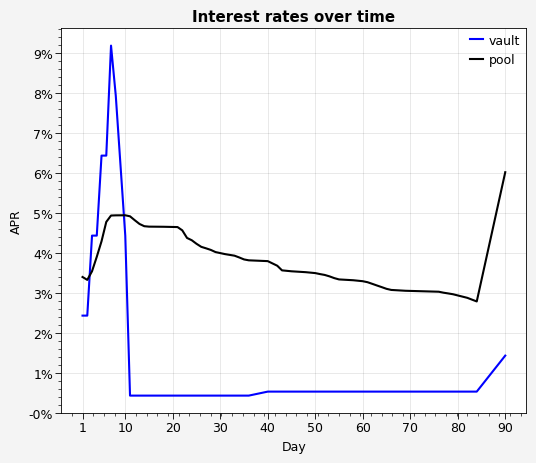

In [12]:
trades_agg = trades.groupby("day").agg(
    {
        "vault_apr": ["mean"],
        "pool_apr": ["mean"],
        "delta_base_abs": ["sum"],
        "vault_apr": ["mean"],
        "agent_0_pnl": ["mean"],
    }
)
trades_agg.columns = ["_".join(col).strip() for col in trades_agg.columns.values]
trades_agg = trades_agg.reset_index()
ax = get_gridspec_subplots()[1][0]
plt.gcf().set_size_inches(6,5)
ax = trades_agg.iloc[0:].plot(x="day", y="vault_apr_mean", ax=ax, label="vault", c='blue')
ax = trades_agg.iloc[0:].plot(x="day", y="pool_apr_mean", ax=ax, label="pool", c='black')
ax.set_title("Interest rates over time")
ax.set_xlabel("Day")
ax.set_ylabel("APR")
ax.legend()

xtick_step = 10
ax.set_xticks([0]+[x for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])
ax.set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])

ylim = ax.get_ylim()
ax.set_ylim(0, ylim[1])
ax.set_yticks([i for i in np.arange(ylim[0], ylim[1], 0.01)])
ax.set_yticklabels([f"{(i):.0%}" for i in ax.get_yticks()])

plt.show() 

It may look like the black line isn't moving at all, until the end. But let's zoom in!

This is a function of two things: random agents being too dumb to concertedly move the rate, as well as the model parameters not being optimized for this scenario.

/var/folders/_k/t9wwf72j6q744qb21qrn90n80000gn/T/ipykernel_90423/2556906885.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([f"{(i/100):.3%}" for i in ax.get_yticks()])


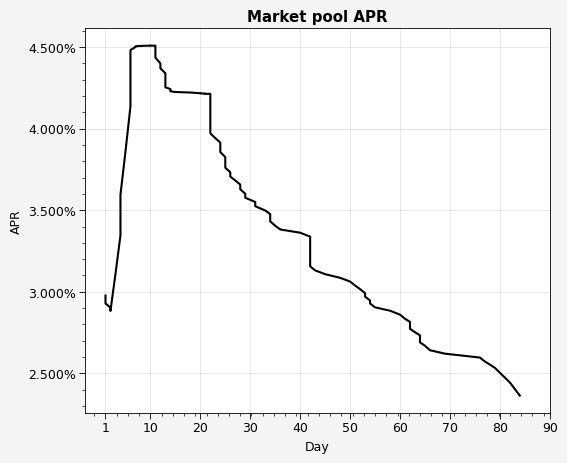

    day  vault_apr_mean  pool_apr_mean  delta_base_abs_sum  agent_0_pnl_mean
0     0          0.0200       0.029654        5.631532e+06        502.726439
1     1          0.0200       0.028931        3.670828e+06        508.530282
2     2          0.0400       0.031088        1.776852e+07        491.617362
3     3          0.0400       0.034703        3.550285e+07        465.041165
4     4          0.0600       0.038579        1.773319e+07        438.510184
5     5          0.0600       0.043425        3.848431e+07        408.388864
6     6          0.0875       0.045020        1.263015e+06        399.055772
7     7          0.0750       0.045066        6.160275e+04        398.951225
8     9          0.0400       0.045083        2.676376e+04        399.103448
9    10          0.0000       0.044823        4.414441e+06        400.670450
10   11          0.0000       0.043843        3.828128e+06        406.487743
11   12          0.0000       0.042914        6.957349e+06        412.001965

In [13]:
fig = output_utils.plot_pool_apr(trades, exclude_first_day=True, exclude_last_day = True)
fig.set_size_inches(6,5)
ax = plt.gca()
ax.properties()['children'][0].set_color('black')
ax.set_yticklabels([f"{(i/100):.3%}" for i in ax.get_yticks()])
ax.set_ylabel("APR")

xtick_step = 10
ax.set_xticks([0]+[x for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])
ax.set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])

plt.show()
print(trades_agg)

These random agents are unable to pick smart entry points. Due to trading on coinflips only, they slowdly bleed fees out of their starting position, which in this case reduces from 1.0 million down to 0.999, a loss of $1k.

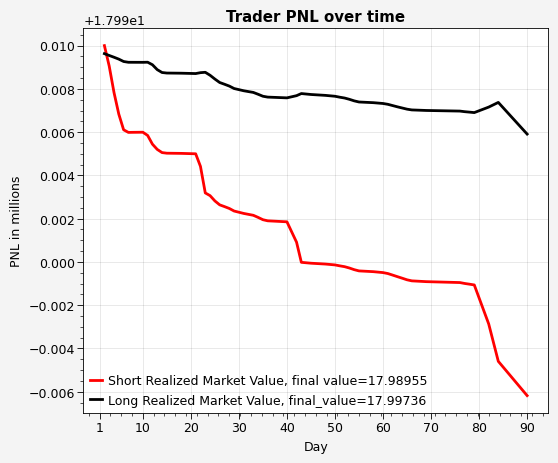

In [14]:
def get_pnl_excluding_agent_0_no_mock_with_day(trades_df: pd.DataFrame) -> pd.DataFrame:
    """Returns Profit and Loss Column for every agent except for agent 0 from post-processing"""
    cols_to_return = ['day']+[col for col in trades_df if col.startswith("agent") and col.endswith("pnl_no_mock")]
    cols_to_return.remove("agent_0_pnl_no_mock")
    return trades_df[cols_to_return]

def plot_pnl(pnl, ax, label, last_day):
    # ax.plot(pnl.iloc[1:,:], linestyle='-', linewidth=0.5, alpha=0.5)
    # separate first half of agents, which are set to trade short
    # from second half of agents, which are set to trade long
    columns = pnl.columns.to_list()
    n = int(len(columns)/2)
    short_pnl = pnl.loc[1:, columns[:n]].mean(axis=1)
    long_pnl = pnl.loc[1:, columns[n:]].mean(axis=1)
    ax.plot(short_pnl, c='red', label=f"Short {label}, final value={short_pnl[len(short_pnl)]:.5f}", linewidth=2)
    ax.plot(long_pnl, c='black', label=f"Long {label}, final_value={long_pnl[len(long_pnl)]:.5f}", linewidth=2)
    # grey area where day is last day
    ax.set_ylabel('PNL in millions')
    # ax.axvspan(last_day, len(short_pnl), color='grey', alpha=0.2, label="Last day")
    ax.legend()

fig, ax = plt.subplots(1, 1, figsize=(6, 5), sharex=True, gridspec_kw={'wspace': 0.0, 'hspace': 0.0})
first_trade_that_is_on_last_day = min(trades.index[trades.day == max(trades.day)])
# data_mock = post_processing.get_pnl_excluding_agent_0(trades)
data_no_mock = get_pnl_excluding_agent_0_no_mock_with_day(trades).groupby('day').mean()
# plot_pnl(pnl=data_mock,label='Mock',ax=ax[0],last_day=first_trade_that_is_on_last_day)
plot_pnl(pnl=data_no_mock,label='Realized Market Value',ax=ax,last_day=first_trade_that_is_on_last_day)

xtick_step = 10
ax.set_xticks([0]+[x for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])
ax.set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])

plt.gca().set_xlabel("Day")
plt.gca().set_title('Trader PNL over time')
# display(data_no_mock)
plt.show()

This plot shows being a Liquidity Provider (LP) is a profitable position, in this scenario where agents are trading randomly.

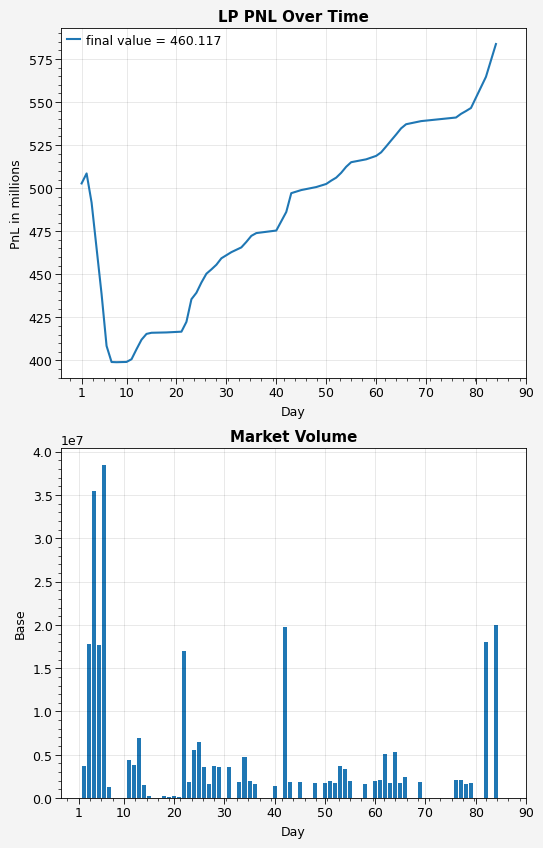

In [15]:
fig, ax = plt.subplots(2,1,figsize=(6, 10))
exclude_last_day = True
num_agents = 1
start_idx = 0
first_trade_that_is_on_last_day = min(trades_agg.index[trades_agg.day == max(trades_agg.day)])
end_idx = first_trade_that_is_on_last_day - 1 if exclude_last_day is True else len(trades_agg)
ax[0].plot(trades_agg.loc[start_idx:end_idx,"day"], trades_agg.loc[start_idx:end_idx,"agent_0_pnl_mean"], label=f"mean = {trades_agg.loc[end_idx,'agent_0_pnl_mean']:.3f}")
ax[0].set_title("LP PNL Over Time")
ax[0].set_ylabel("PNL")
ax[0].set_xlabel("Day")
data = trades.loc[0:first_trade_that_is_on_last_day-1,"agent_0_pnl"]
xtick_step = 10
ax[0].set_xticks([0]+[x for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])
ax[0].set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])
ax[0].legend({f"final value = {data.values[len(data)-1]:,.3f}"})
ax[0].set_ylabel("PnL in millions")

exclude_first_trade = True
exclude_last_trade = True
start_idx = 1 if exclude_first_trade else 0
end_idx = first_trade_that_is_on_last_day - 1 if exclude_last_trade is True else None
ax[1].bar(trades_agg.loc[start_idx:end_idx,"day"], trades_agg.loc[start_idx:end_idx,"delta_base_abs_sum"], label=f"mean = {trades_agg.loc[end_idx,'delta_base_abs_sum']:.3f}")
ax[1].set_title("Market Volume")
ax[1].set_ylabel("Base")
ax[1].set_xlabel("Day")
xtick_step = 10
ax[1].set_xticks([0]+[x for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])
ax[1].set_xticklabels(['1']+[str(x+1) for x in range(9, simulator.config.simulator.num_trading_days + 1, xtick_step)])
ylim = ax[1].get_ylim()
ax[1].set_ylim(0, ylim[1])
plt.show()

## We are constantly updating our research. Stay tuned for more!

TODO:
- parameter optimization
- smart agents
- multiple simulation trial runs to evaluate LP profitability
- simulate Aave, Compound, MakerDao, etc.